# Apple Support Chatbot Using Twitter Data

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import spacy
import nltk
import tensorflow as tf
from tensorflow import keras
import sklearn
import math


from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import yaml
import collections

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input
from keras.models import load_model

# Word Embeddings
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TweetTokenizer
import gensim

# Doc2Vec
from nltk.tokenize import word_tokenize 
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

## Data from Twitter

https://www.kaggle.com/thoughtvector/customer-support-on-twitter
- It is about customer support on tweet by different company

In [2]:
tweet = pd.read_csv('twcs.csv')
tweet.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


In [3]:
## Finding the different author in the data
author = tweet.groupby('author_id')['text'].count()
print(author)

## length of the dataframe
len(tweet), len(author)

author_id
10026                  3
100363                 1
10103                  2
10221                  2
10286                  1
                   ...  
mediatemplehelp      305
nationalrailenq     4444
sainsburys         19466
sizehelpteam        1482
sprintcare         22381
Name: text, Length: 702777, dtype: int64


(2811774, 702777)

In [4]:
author.nlargest(10)

author_id
AmazonHelp         169840
AppleSupport       106860
Uber_Support        56270
SpotifyCares        43265
Delta               42253
Tesco               38573
AmericanAir         36764
TMobileHelp         34317
comcastcares        33031
British_Airways     29361
Name: text, dtype: int64

- So there are 2.8 millions tweets and 700,000 different author_id
- Let's see the top 15

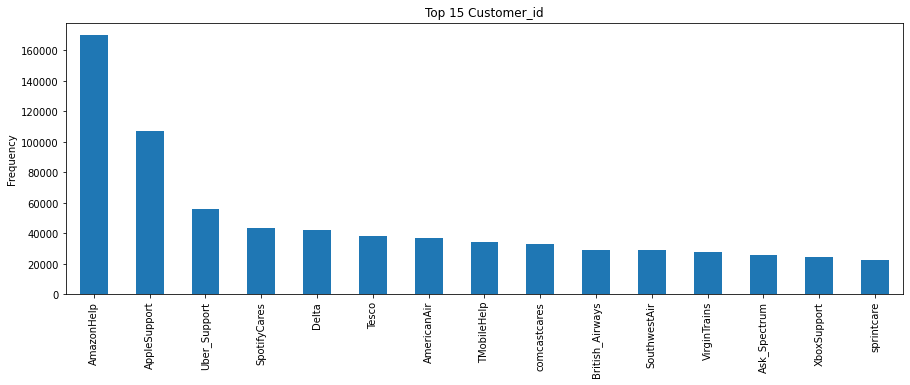

In [5]:
author.nlargest(15).plot(kind='bar',figsize=(15, 5))
plt.xlabel('')
plt.ylabel('Frequency')
plt.title('Top 15 Customer_id')
plt.savefig('top_15 customer_id', bbox_inches='tight')
plt.show()

In [6]:
## let's see unique customer_id and company
## by checking the inbound column we can see whether or not if it is the customer or not
unique_id = (len(tweet[tweet.inbound == False].author_id.unique()), len(tweet[tweet.inbound == True].author_id.unique()))
print(f'# of companies: {unique_id[0]}, # of customer: {unique_id[1]}')

# of companies: 108, # of customer: 702669


### Data Dictionary

The dataset is a CSV, where each row is a tweet. The different columns are described below. Every conversation included has at least one request from a consumer and at least one response from a company. Which user IDs are company user IDs can be calculated using the inbound field.

* tweet_id:
A unique, anonymized ID for the Tweet. Referenced by response_tweet_id and in_response_to_tweet_id.

* author_id:
A unique, anonymized user ID. @s in the dataset have been replaced with their associated anonymized user ID.

* inbound:
Whether the tweet is "inbound" to a company doing customer support on Twitter. This feature is useful when re-organizing data for training conversational models.

* created_at:
Date and time when the tweet was sent.

* text:
Tweet content. Sensitive information like phone numbers and email addresses are replaced with mask values like __email__.

* response_tweet_id:
IDs of tweets that are responses to this tweet, comma-separated.

* in_response_to_tweet_id:
ID of the tweet this tweet is in response to, if any.

#### Amazon has too many language for this work on english

## Apple Support
- Creating a chatbot too broad and get us into lot of error by the bot because most customer support ask similar question, it can create internel errors
- Narrow it down to only Apple because Amazon has a lot of different languages in the text

In [7]:
ap = tweet[tweet['author_id'] == 'AppleSupport']
ap.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106860 entries, 396 to 2811541
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   tweet_id                 106860 non-null  int64  
 1   author_id                106860 non-null  object 
 2   inbound                  106860 non-null  bool   
 3   created_at               106860 non-null  object 
 4   text                     106860 non-null  object 
 5   response_tweet_id        31564 non-null   object 
 6   in_response_to_tweet_id  106719 non-null  float64
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 5.8+ MB


In [8]:
## we still have over 100,000 of data, so chatbot would be still decent
ap.shape

(106860, 7)

In [9]:
## we need to drop all the na for in_response_to_tweet_id because it shows the id of the tweet that this tweet is in response
ap.dropna(subset = ['in_response_to_tweet_id'], inplace = True)
## converting in_response_to_tweet_id to int
ap['in_response_to_tweet_id'] = ap['in_response_to_tweet_id'].astype('int64')
ap.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106719 entries, 396 to 2811541
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   tweet_id                 106719 non-null  int64 
 1   author_id                106719 non-null  object
 2   inbound                  106719 non-null  bool  
 3   created_at               106719 non-null  object
 4   text                     106719 non-null  object
 5   response_tweet_id        31423 non-null   object
 6   in_response_to_tweet_id  106719 non-null  int64 
dtypes: bool(1), int64(2), object(4)
memory usage: 5.8+ MB


<ipython-input-9-74ffd78d6e53>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ap.dropna(subset = ['in_response_to_tweet_id'], inplace = True)
<ipython-input-9-74ffd78d6e53>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ap['in_response_to_tweet_id'] = ap['in_response_to_tweet_id'].astype('int64')


In [10]:
ap.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
396,696,AppleSupport,False,Tue Oct 31 22:27:49 +0000 2017,@115854 We're here for you. Which version of t...,697,698
398,699,AppleSupport,False,Tue Oct 31 22:36:27 +0000 2017,@115854 Lets take a closer look into this issu...,NaN,697
401,701,AppleSupport,False,Tue Oct 31 22:26:49 +0000 2017,@115855 Let's go to DM for the next steps. DM ...,NaN,702
403,703,AppleSupport,False,Tue Oct 31 22:09:52 +0000 2017,@115855 Any steps tried since it started last ...,702,704
405,705,AppleSupport,False,Tue Oct 31 21:57:00 +0000 2017,@115855 That's great it has iOS 11.1 as we can...,"706,704",707


* now we need the match those text to the orginal in_response_to_tweet_id
* we can merge the orginal dataframe with the apple one
* we need the tweet_id and the text from the orginal one

In [11]:
ap = pd.merge(tweet[['tweet_id', 'text']], ap,left_on = 'tweet_id', right_on = 'in_response_to_tweet_id')
ap.head()

,tweet_id_x,text_x,tweet_id_y,author_id,inbound,created_at,text_y,response_tweet_id,in_response_to_tweet_id
0,697,@AppleSupport The newest update. I️ made sure ...,699,AppleSupport,False,Tue Oct 31 22:36:27 +0000 2017,@115854 Lets take a closer look into this issu...,NaN,697
1,698,@AppleSupport https://t.co/NV0yucs0lB,696,AppleSupport,False,Tue Oct 31 22:27:49 +0000 2017,@115854 We're here for you. Which version of t...,697,698
2,702,@AppleSupport Tried resetting my settings .. r...,701,AppleSupport,False,Tue Oct 31 22:26:49 +0000 2017,@115855 Let's go to DM for the next steps. DM ...,NaN,702
3,704,@AppleSupport This is what it looks like https...,703,AppleSupport,False,Tue Oct 31 22:09:52 +0000 2017,@115855 Any steps tried since it started last ...,702,704
4,707,@AppleSupport I️ have an iPhone 7 Plus and yes...,705,AppleSupport,False,Tue Oct 31 21:57:00 +0000 2017,@115855 That's great it has iOS 11.1 as we can...,"706,704",707


In [12]:
## Dropping the unnesccary columns
ap.drop(columns = ['tweet_id_x', 'tweet_id_y', 'inbound', 'in_response_to_tweet_id', 'response_tweet_id'], inplace = True)
ap.head()

,text_x,author_id,created_at,text_y
0,@AppleSupport The newest update. I️ made sure ...,AppleSupport,Tue Oct 31 22:36:27 +0000 2017,@115854 Lets take a closer look into this issu...
1,@AppleSupport https://t.co/NV0yucs0lB,AppleSupport,Tue Oct 31 22:27:49 +0000 2017,@115854 We're here for you. Which version of t...
2,@AppleSupport Tried resetting my settings .. r...,AppleSupport,Tue Oct 31 22:26:49 +0000 2017,@115855 Let's go to DM for the next steps. DM ...
3,@AppleSupport This is what it looks like https...,AppleSupport,Tue Oct 31 22:09:52 +0000 2017,@115855 Any steps tried since it started last ...
4,@AppleSupport I️ have an iPhone 7 Plus and yes...,AppleSupport,Tue Oct 31 21:57:00 +0000 2017,@115855 That's great it has iOS 11.1 as we can...


In [13]:
## renaming them
ap.rename(columns = {'text_x': 'customer_text', 'text_y': 'apple_text', 'created_at': 'date'}, inplace = True)
ap.head()

,customer_text,author_id,date,apple_text
0,@AppleSupport The newest update. I️ made sure ...,AppleSupport,Tue Oct 31 22:36:27 +0000 2017,@115854 Lets take a closer look into this issu...
1,@AppleSupport https://t.co/NV0yucs0lB,AppleSupport,Tue Oct 31 22:27:49 +0000 2017,@115854 We're here for you. Which version of t...
2,@AppleSupport Tried resetting my settings .. r...,AppleSupport,Tue Oct 31 22:26:49 +0000 2017,@115855 Let's go to DM for the next steps. DM ...
3,@AppleSupport This is what it looks like https...,AppleSupport,Tue Oct 31 22:09:52 +0000 2017,@115855 Any steps tried since it started last ...
4,@AppleSupport I️ have an iPhone 7 Plus and yes...,AppleSupport,Tue Oct 31 21:57:00 +0000 2017,@115855 That's great it has iOS 11.1 as we can...


## Preprocessing 

In [14]:
# stopwords from nltk
stop_words = set(stopwords.words('english'))
# lemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()

ct = ap['customer_text']
ct 

0         @AppleSupport The newest update. I️ made sure ...
1                    @AppleSupport  https://t.co/NV0yucs0lB
2         @AppleSupport Tried resetting my settings .. r...
3         @AppleSupport This is what it looks like https...
4         @AppleSupport I️ have an iPhone 7 Plus and yes...
                                ...                        
106643    anyone having issues with #osx #HighSierra and...
106644    Hey @AppleSupport - not being able to duplicat...
106645    Yo @AppleSupport is that weird glitch w/ the c...
106646    What the fuck @AppleSupport  my phone keeps ha...
106647    Is anyone having #iphone issues with there pho...
Name: customer_text, Length: 106648, dtype: object

### Making all the words lower case

In [15]:
## converting to all lower case
ct = ct.str.lower()
ct

0         @applesupport the newest update. i️ made sure ...
1                    @applesupport  https://t.co/nv0yucs0lb
2         @applesupport tried resetting my settings .. r...
3         @applesupport this is what it looks like https...
4         @applesupport i️ have an iphone 7 plus and yes...
                                ...                        
106643    anyone having issues with #osx #highsierra and...
106644    hey @applesupport - not being able to duplicat...
106645    yo @applesupport is that weird glitch w/ the c...
106646    what the fuck @applesupport  my phone keeps ha...
106647    is anyone having #iphone issues with there pho...
Name: customer_text, Length: 106648, dtype: object

### Tokenzing, Lemmitzing, Remove the href

In [16]:
token = TweetTokenizer(reduce_len = True, strip_handles = True)
## this limits repeated character to 3 with reduce_len and strip_handles remove all the @
for i in range(len(ct)):
    ## remove the https://
    ct[i] = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', ct[i])
    ## to remove non-english tweet
    ct[i] = re.sub("[^a-zA-Z0-9]+", " ", ct[i])
    ## Lemmatize for converting a word to it's base form
    ct[i] = lemmatizer.lemmatize(ct[i])
    ct[i] = re.findall(r"\w+", ct[i])
ct

0         [applesupport, the, newest, update, i, made, s...
1                                            [applesupport]
2         [applesupport, tried, resetting, my, settings,...
3           [applesupport, this, is, what, it, looks, like]
4         [applesupport, i, have, an, iphone, 7, plus, a...
                                ...                        
106643    [anyone, having, issues, with, osx, highsierra...
106644    [hey, applesupport, not, being, able, to, dupl...
106645    [yo, applesupport, is, that, weird, glitch, w,...
106646    [what, the, fuck, applesupport, my, phone, kee...
106647    [is, anyone, having, iphone, issues, with, the...
Name: customer_text, Length: 106648, dtype: object

### Stopwords 

In [17]:
## to remove the applesupport from the processed_text
stop_words.add('applesupport')
stop_words.add('115858')

In [18]:
for i in range(len(ct)):
    word = []
    for j in ct[i]:
        if j in stop_words:
            None
        else:
            word.append(j)
    ct[i] = word 


In [19]:
ct[4]

['iphone', '7', 'plus', 'yes']

## Settings a limit on the lenght of the tweet

In [20]:
min_length = 5
max_length = 40
## despite the tweeter character limit of 140
## average character of tweet is 28, so 40 seems reasonable
## tweets needs to be between 6-40
for i in range(len(ct)):
    if len(ct[i]) > max_length:
        ct[i] = np.nan
    elif len(ct[i]) <= min_length:
        ct[i] = np.nan


In [21]:
## delete the empty tweet
ct.dropna(inplace = True)
ct[:5]

0     [newest, update, made, sure, download, yesterday]
6     [hey, anyone, else, upgraded, ios11, 1, issues...
12    [hello, internet, someone, explain, symbol, ke...
13    [got, screenshot, saying, iphonex, reserved, 3...
15    [thank, updated, phone, even, slower, barely, ...
Name: customer_text, dtype: object

In [22]:
## we have filtered out about 12,000 tweets
len(ct)

80118

### Merging the processd_text back to the dataframe

In [23]:
ap.head()

,customer_text,author_id,date,apple_text
0,@AppleSupport The newest update. I️ made sure ...,AppleSupport,Tue Oct 31 22:36:27 +0000 2017,@115854 Lets take a closer look into this issu...
1,@AppleSupport https://t.co/NV0yucs0lB,AppleSupport,Tue Oct 31 22:27:49 +0000 2017,@115854 We're here for you. Which version of t...
2,@AppleSupport Tried resetting my settings .. r...,AppleSupport,Tue Oct 31 22:26:49 +0000 2017,@115855 Let's go to DM for the next steps. DM ...
3,@AppleSupport This is what it looks like https...,AppleSupport,Tue Oct 31 22:09:52 +0000 2017,@115855 Any steps tried since it started last ...
4,@AppleSupport I️ have an iPhone 7 Plus and yes...,AppleSupport,Tue Oct 31 21:57:00 +0000 2017,@115855 That's great it has iOS 11.1 as we can...


In [24]:
## using index to merge the processed_tweet
customer_tweet = ap['customer_text'].loc[ct.index]
apple_tweet = ap['apple_text'].loc[ct.index]

## new and clean dataframe
df = pd.DataFrame({'processed_tweet': ct, 'customer_tweet': customer_tweet, 'apple_tweet': apple_tweet})
df.head()

,processed_tweet,customer_tweet,apple_tweet
0,"[newest, update, made, sure, download, yesterday]",@AppleSupport The newest update. I️ made sure ...,@115854 Lets take a closer look into this issu...
6,"[hey, anyone, else, upgraded, ios11, 1, issues...",Hey @AppleSupport and anyone else who upgraded...,"@115856 Hey, let's work together to figure out..."
12,"[hello, internet, someone, explain, symbol, ke...","Hello, internet. Can someone explain why this ...",@115861 You're in the right place; we'll do al...
13,"[got, screenshot, saying, iphonex, reserved, 3...",@AppleSupport I’ve got a screenshot saying my ...,@115863 Go ahead and send us a DM please. Let ...
15,"[thank, updated, phone, even, slower, barely, ...",Thank you @AppleSupport I updated my phone and...,"@115864 We'd like to help, but we'll need more..."


## INTENT and Keyword Searching
- in order for the chatbot to know how to response to the incoming text we need to identify keywords that can response based on the keyword or intent

In [25]:
## searching intents
ios = [(i,j) for i,j in enumerate(df['processed_tweet']) if 'ios' in j]
ios_tweet = df.iloc[[i[0] for i in ios]]
print(len(ios_tweet))
ios_tweet.head()

14328


,processed_tweet,customer_tweet,apple_tweet
55,"[ios, 11, 1, getting, worse, months]",@AppleSupport iOS 11.1 it’s been getting worse...,@116337 Please meet with us in DM. We'd like t...
59,"[updated, ios, iphone7, icloud, backup, greyed...","@115858 Just updated iOS on iPhone7, now iClou...",@116339 Check out this link: https://t.co/Lr8z...
64,"[bug, calendar, app, fixed, upgraded, ios, 11,...",@115858 when will the bug in the calendar app ...,@116342 We'd like to help. What is going on wi...
77,"[sorted, thanks, ios, update, needed, change, ...",@AppleSupport It’s sorted. Thanks. iOS update ...,@116351 We're glad to hear that's sorted out f...
78,"[ios, 11, 0, 3, 6s, cannot, adjust, alarm, vol...",@AppleSupport ios 11.0.3 on 6s. Cannot adjust ...,@116351 We'd love to help with your alarm volu...


### INTENTS

In [26]:
intents = {"greeting": ["hi there", "how are you?", "is anyone there?","hey","hola", "hello", "good day"],
          "update": ['update', 'download'],
          "upgrade": ['upgraded', 'new'],
          "app" : ['app', 'crash'],
          "ios_update" : ['ios', 'icloud'],
          "battery": ['battery'],
          "mac": ['mac', 'macbook', 'laptop'],
          'music': ['itunes', 'music', 'songs'], 
          'forgot_password': ['login', 'password', 'account', 'forgot password'],
          'repair': ['repair', 'fix', 'broken', 'slow'],
          'payment': ['credit', 'card', 'payment', 'pay']}

In [27]:
def get_key_tweets(series, keywords):
    keyword_tweets = []
    for tweet in series:
        # Want to check if keyword is in tweets
        for keyword in keywords:
            if keyword in tweet:
                keyword_tweets.append(tweet)
    return keyword_tweets

In [29]:
len(get_key_tweets(df['processed_tweet'], 'greeting'))

2072

In [30]:
intent_lengths = [len(get_key_tweets(df['processed_tweet'], intents[intent])) for intent in intents.keys()]
intent_lengths

[4134, 14824, 8818, 4733, 15719, 7566, 2844, 4797, 1784, 12703, 1752]

In [31]:
keyword = pd.DataFrame({'intents': list(intents.keys()), 'intent_lengths': intent_lengths}).sort_values('intent_lengths', ascending = False)
keyword.head()

,intents,intent_lengths
4,ios_update,15719
1,update,14824
9,repair,12703
2,upgrade,8818
5,battery,7566


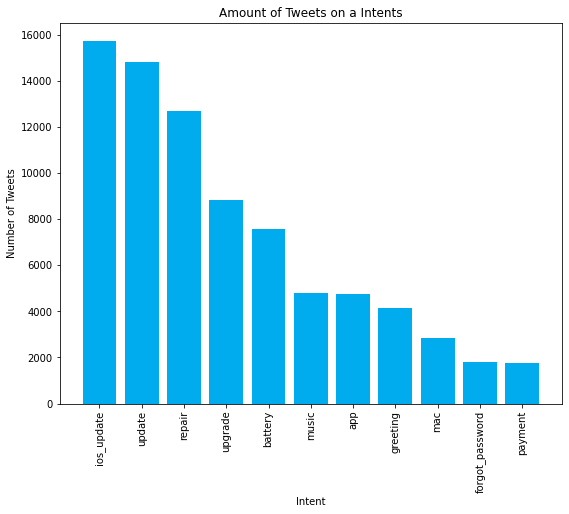

In [32]:
# Visualization
plt.figure(figsize=(9,7))
plt.bar(keyword['intents'], keyword['intent_lengths'], color = '#00acee')
plt.title('Amount of Tweets on a Intents')
plt.xlabel('Intent')
plt.xticks(rotation=90)
plt.ylabel('Number of Tweets')
plt.savefig('intents.png', bbox_inches='tight')
plt.show()

In [33]:
keywords = keyword['intents']

non_keyword_tweets = []
for tweet in df['processed_tweet']:
    if not any(i in tweet for i in keywords):
        non_keyword_tweets.append(tweet)
non_keyword_tweets[:2]

[['hello',
  'internet',
  'someone',
  'explain',
  'symbol',
  'keeps',
  'appearing',
  'phone',
  'try',
  'type',
  'letter',
  'also'],
 ['got',
  'screenshot',
  'saying',
  'iphonex',
  'reserved',
  '3rd',
  'email',
  'saying',
  '18th',
  'happened']]

## Data Training and Generating 

In [34]:
intents

{'greeting': ['hi there',
  'how are you?',
  'is anyone there?',
  'hey',
  'hola',
  'hello',
  'good day'],
 'update': ['update', 'download'],
 'upgrade': ['upgraded', 'new'],
 'app': ['app', 'crash'],
 'ios_update': ['ios', 'icloud'],
 'battery': ['battery'],
 'mac': ['mac', 'macbook', 'laptop'],
 'music': ['itunes', 'music', 'songs'],
 'forgot_password': ['login', 'password', 'account', 'forgot password'],
 'repair': ['repair', 'fix', 'broken', 'slow'],
 'payment': ['credit', 'card', 'payment', 'pay']}

In [35]:
extra_tweets = {'update': 'update download new',
           'forgot_password': 'login password account lost',
           'info': 'info information',
           'battery': 'battery power',
           'location': 'nearest apple location store'}
new = list(extra_tweets.values())
new = pd.Series(new)
extra_df = df['processed_tweet'].copy()
for i in extra_df.index:
    extra_df[i] = str(" ".join(extra_df[i]))
extra_df

0                newest update made sure download yesterday
6         hey anyone else upgraded ios11 1 issues capita...
12        hello internet someone explain symbol keeps ap...
13        got screenshot saying iphonex reserved 3rd ema...
15        thank updated phone even slower barely works t...
                                ...                        
106643    anyone issues osx highsierra slack zoom multip...
106644    hey able duplicate file pages searched really ...
106645    yo weird glitch w capital attempt make tweets ...
106646    fuck phone keeps hanging calls showing call fa...
106647    anyone iphone issues phone freezing randomly 7...
Name: processed_tweet, Length: 80118, dtype: object

In [36]:
extra_df = pd.concat([extra_df, new], axis = 0)
extra_df

0            newest update made sure download yesterday
6     hey anyone else upgraded ios11 1 issues capita...
12    hello internet someone explain symbol keeps ap...
13    got screenshot saying iphonex reserved 3rd ema...
15    thank updated phone even slower barely works t...
                            ...                        
0                                   update download new
1                           login password account lost
2                                      info information
3                                         battery power
4                          nearest apple location store
Length: 80123, dtype: object

### Uncomment it if you don't have the model already, it takes a long time to run

In [37]:
## don't run it it takes a lot of time, just load the model
## TaggedDocument tagged each data with an id 
# data = [TaggedDocument(words = word_tokenize(j.lower()), tags = [str(i)])  for i, j in enumerate(extra_df)]
# ## Instantiate the model
# model = Doc2Vec(vector_size = 10, alpha = 0.025, min_alpha= 0.00025, min_count = 1, dm = 1)
# model.build_vocab(data)
# for i in range(50):    
#     model.train(data, total_examples = model.corpus_count, epochs = model.epochs)
#     model.alpha -= 0.0002
#     model.min_alpha = model.alpha
# model.save('Doc2Vec_model')

In [38]:
model = Doc2Vec.load('Doc2Vec_model')
doc2vec = np.array([model.docvecs[i] for i in range(extra_df.shape[0])])
doc2vec

<ipython-input-38-71d057a83da6>:2: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  doc2vec = np.array([model.docvecs[i] for i in range(extra_df.shape[0])])


array([[-2.21213   ,  3.5645392 , -1.9339312 , ...,  3.2990324 ,
         5.564972  , -0.70876384],
       [-8.694999  , -0.9035936 ,  4.2110004 , ...,  5.0546193 ,
         5.286602  , -0.8092168 ],
       [ 6.332759  , -2.857031  ,  1.4225491 , ...,  0.10111625,
         3.643376  , -3.1269062 ],
       ...,
       [ 2.2974558 ,  1.193835  ,  0.31321618, ..., -0.09734522,
         1.692781  , -4.249531  ],
       [-0.32686153, -1.5296396 , -2.2415874 , ...,  3.6393542 ,
        -1.8085347 , -0.3786013 ],
       [ 0.27811956,  3.304985  ,  0.51724523, ...,  3.2651856 ,
        -2.4683857 , -6.875318  ]], dtype=float32)

In [39]:
doc2vec.shape

(80123, 10)

In [40]:
## intents
intents2 = {'Battery': ['io', 'drain', 'battery', 'iphone', 'twice', 'fast', 'io', 'help'],
    'Update': ['new', 'update', 'i️', 'make', 'sure', 'download', 'yesterday'],
    'iphone': ['instal', 'io', 'make', 'iphone', 'slow', 'work', 'properly', 'help'],
    'app': ['app', 'still', 'longer', 'able', 'control', 'lockscreen'],
    'mac': ['help','mac','app','store','open','can','not','update','macbook','pro','currently','run','o','x',
  'yosemite'], 'greeting': ['hi', 'hello', 'yo', 'hey', 'whats', 'up']
    }

In [41]:
extra_tweets

{'update': 'update download new',
 'forgot_password': 'login password account lost',
 'info': 'info information',
 'battery': 'battery power',
 'location': 'nearest apple location store'}

In [43]:
model.docvecs.most_similar('80118')

<ipython-input-43-38d2e675138e>:1: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  model.docvecs.most_similar('80118')


[('160', 0.9570398926734924),
 ('46406', 0.9408049583435059),
 ('73985', 0.9372326135635376),
 ('61423', 0.9367526173591614),
 ('33597', 0.9346528649330139),
 ('62684', 0.9323944449424744),
 ('46780', 0.9316598773002625),
 ('13936', 0.9297910928726196),
 ('5191', 0.929779052734375),
 ('49118', 0.9290613532066345)]

In [48]:
similar_doc = model.docvecs.most_similar('80120', topn = 1000)
similar_doc[:4]

<ipython-input-48-3a8b5fbea304>:1: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  similar_doc = model.docvecs.most_similar('80120', topn = 1000)


[('73141', 0.9471955895423889),
 ('10262', 0.9436327219009399),
 ('18906', 0.9429668188095093),
 ('18649', 0.9395617246627808)]

In [44]:
intents_tags = {'update': '80118', 'forgot_password': '80119', 'info': '80120','battery': '80121', 'location': '80122'}
intents_tags

{'update': '80118',
 'forgot_password': '80119',
 'info': '80120',
 'battery': '80121',
 'location': '80122'}

In [45]:
list(ct.iloc[[10,1]].values)

[['need', 'something', 'battery', 'life', 'sucks', 'ass'],
 ['hey',
  'anyone',
  'else',
  'upgraded',
  'ios11',
  '1',
  'issues',
  'capital',
  'mail',
  'app',
  'puts']]

In [46]:
type(ct)

pandas.core.series.Series

In [51]:
## create some intent
def generate_intent(target, itag):
    similar_doc = model.docvecs.most_similar(itag,topn = target)
    # Getting just the indexes
    indexes = [int(i[0]) for i in similar_doc]

    return list(ct.iloc[indexes].values)

def insert_manually(target, prototype):
    factor = math.ceil(target / len(prototype))
    content = prototype * factor
    return [content[i] for i in range(target)]

def insert_hybrid(manual_target, generated_target, prototype, itag):
    return insert_manually(manual_target, prototype) + list(generate_intent(generated_target, itag))

In [52]:
## storing the intents 
train = pd.DataFrame()

# adding to the train df
for intent_name, itag in intents_tags.items():
    train[intent_name] = generate_intent(1000, itag)


manually_added_intents = {
    'speak_representative': [['talk','human','please'],
                             ['let','me','talk','to','apple','support'], 
                             ['can','i','speak','agent','person']], 
    'greeting': [['hi'],['hello'], ['whats','up'], ['good','morning'],
                 ['good','evening'], ['good','night']],
    'goodbye': [['goodbye'],['bye'],['thank'],['thanks'], ['done']] }


# Updating training data
for intent_name in manually_added_intents.keys():
    train[intent_name] = insert_manually(1000, [*manually_added_intents[intent_name]])

# 3. Adding in the new intents

new_intents = {'update':(300,700,[['want','update'], ['update','not','working'], 
                                     ['phone','need','update']], 
                            intents_tags['update']),
                  'info': (800,200, [['need','information'], 
                                       ['want','to','know','about'], ['what','are','macbook','stats'],
                                    ['any','info','next','release','?']], 
                             intents_tags['info']),
                  'forgot_password': (600,400, [['forgot','my','pass'], ['forgot','my','login'
                                ,'details'], ['cannot','log','in','password'],['lost','account','recover','password']], 
                             intents_tags['forgot_password'])
                 }
# Updating training data
for intent_name, args in new_intents.items():
    train[intent_name] = insert_hybrid(*args)

training = pd.DataFrame(train.T.unstack()).reset_index().iloc[:,1:].rename(columns={'level_1':'Intent', 0: 'Utterance'})
# Reordering
training = training[['Utterance','Intent']]


print(train.shape)
train.head()

(1000, 8)


<ipython-input-51-aab686ff6639>:3: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  similar_doc = model.docvecs.most_similar(itag,topn = target)


,update,forgot_password,info,battery,location,speak_representative,greeting,goodbye
0,"[want, update]","[forgot, my, pass]","[need, information]","[since, updating, 11, 1, battery, life, 6s, ab...","[188, 37613, 11968, 37614, solution, chat, sid...","[talk, human, please]",[hi],[goodbye]
1,"[update, not, working]","[forgot, my, login, details]","[want, to, know, about]","[bedtime, alarms, work, slept, many, times, si...","[check, airpods, warranty, check, coverage, pa...","[let, me, talk, to, apple, support]",[hello],[bye]
2,"[phone, need, update]","[cannot, log, in, password]","[what, are, macbook, stats]","[ios, 11, totally, destroyed, iphone, 6, batte...","[hi, apple, check, iphone, battery, health, wi...","[can, i, speak, agent, person]","[whats, up]",[thank]
3,"[want, update]","[lost, account, recover, password]","[any, info, next, release, ?]","[silent, mode, swtch, wch, abve, vol, cntrl, b...","[smart, cover, case, 2nd, gen, 12, 9, inch, ip...","[talk, human, please]","[good, morning]",[thanks]
4,"[update, not, working]","[forgot, my, pass]","[need, information]","[ios, 11, 0, 3, draining, iphone, 7, battery, ...","[friend, mac, book, pro, 2016, screen, color, ...","[let, me, talk, to, apple, support]","[good, evening]",[done]


In [49]:
training.head()

,Utterance,Intent
0,"[want, update]",update
1,"[forgot, my, pass]",forgot_password
2,"[need, information]",info
3,"[since, updating, 11, 1, battery, life, 6s, ab...",battery
4,"[188, 37613, 11968, 37614, solution, chat, sid...",location


## Modeling

In [54]:
X = training['Utterance']
y = training['Intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, stratify = y, random_state = 42, test_size = 0.20)

https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
- Using word embedding in the model

In [55]:
### make the labels into number for the modeling
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [56]:
max_length = len(max(X_train, key = len))
max_length

39

In [57]:
## for the modeling we need to convert the words into number for the X as well
## Use pad_sequences to convert it
token = Tokenizer()
token.fit_on_texts(X_train)
X_train = pad_sequences(token.texts_to_sequences(X_train), maxlen = 32, padding = 'post')
X_test = pad_sequences(token.texts_to_sequences(X_test), maxlen = 32, padding = 'post')
vocab_size = len(token.word_counts) + 1
vocab_size

4656

In [58]:
X_train.shape, X_test.shape

((7200, 32), (1800, 32))

https://nlp.stanford.edu/projects/glove/
- pre-trained word vector for twitter 
- https://www.kaggle.com/baodier/glovetwitter27b50dtxt

In [59]:
# Using gloVe word embeddings
embeddings_index = {}
f = open('glove.twitter.27B.50d.txt', encoding = 'utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


In [60]:
word_index = token.word_index
EMBEDDING_DIM = 50 # Because we are using the 50D gloVe embeddings

# Getting my embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [61]:
embedding_matrix, embedding_matrix.shape

(array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.36294001, -0.26519001, -1.30439997, ..., -0.22002   ,
         -0.74168998,  0.56022   ],
        [ 0.51418   , -0.19196001, -0.79962999, ..., -0.34937999,
         -1.08060002,  0.60174   ],
        ...,
        [-0.66701001, -0.38519999,  0.42500001, ..., -0.41330999,
          0.41679001, -0.31400001],
        [ 0.2243    ,  0.16221   , -0.18559   , ...,  0.22480001,
          0.42104   , -0.14382   ],
        [-0.57239997, -0.45877001,  0.067503  , ..., -0.33575001,
          0.1743    ,  1.29509997]]),
 (4656, 50))

In [117]:
## Training the model
model = Sequential()
# Adding layers - For embedding layer, I made sure to add my embedding matrix into the weights paramater
model.add(Embedding(vocab_size, embedding_matrix.shape[1], input_length = 32, 
                        trainable = False, weights = [embedding_matrix]))
    
model.add(Bidirectional(LSTM(128)))

model.add(Dense(600, activation = "relu",kernel_regularizer ='l2')) 
    
# Adding another dense layer to increase model complexity
model.add(Dense(600, activation = "relu",kernel_regularizer ='l2'))
    
# Only update 50 percent of the nodes - helps with overfitting
model.add(Dropout(0.5))
    
# This last layer should be the size of the number of your intents!
model.add(Dense(10, activation = "softmax"))
print("model is created")

model is created


In [118]:
model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = "adam", metrics = ["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 32, 50)            232800    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               183296    
_________________________________________________________________
dense_6 (Dense)              (None, 600)               154200    
_________________________________________________________________
dense_7 (Dense)              (None, 600)               360600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 600)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                6010      
Total params: 936,906
Trainable params: 704,106
Non-trainable params: 232,800
__________________________________________

In [119]:
hist = model.fit(X_train, y_train, epochs=20, batch_size=5, verbose=1, validation_data = (X_test, y_test))
model.save('applebot_model.h5', hist)

Epoch 1/20
1440/1440 [==============================] - 23s 16ms/step - loss: 0.9847 - accuracy: 0.8203 - val_loss: 0.4508 - val_accuracy: 0.9122
Epoch 2/20
1440/1440 [==============================] - 23s 16ms/step - loss: 0.4044 - accuracy: 0.9122 - val_loss: 0.3606 - val_accuracy: 0.9144
Epoch 3/20
1440/1440 [==============================] - 22s 15ms/step - loss: 0.3228 - accuracy: 0.9243 - val_loss: 0.2847 - val_accuracy: 0.9272
Epoch 4/20
1440/1440 [==============================] - 20s 14ms/step - loss: 0.2681 - accuracy: 0.9375 - val_loss: 0.2898 - val_accuracy: 0.9128
Epoch 5/20
1440/1440 [==============================] - 23s 16ms/step - loss: 0.2246 - accuracy: 0.9472 - val_loss: 0.2403 - val_accuracy: 0.9406
Epoch 6/20
1440/1440 [==============================] - 21s 15ms/step - loss: 0.1918 - accuracy: 0.9581 - val_loss: 0.2549 - val_accuracy: 0.9350
Epoch 7/20
1440/1440 [==============================] - 22s 16ms/step - loss: 0.1658 - accuracy: 0.9636 - val_loss: 0.2256 -

In [116]:
hist.history

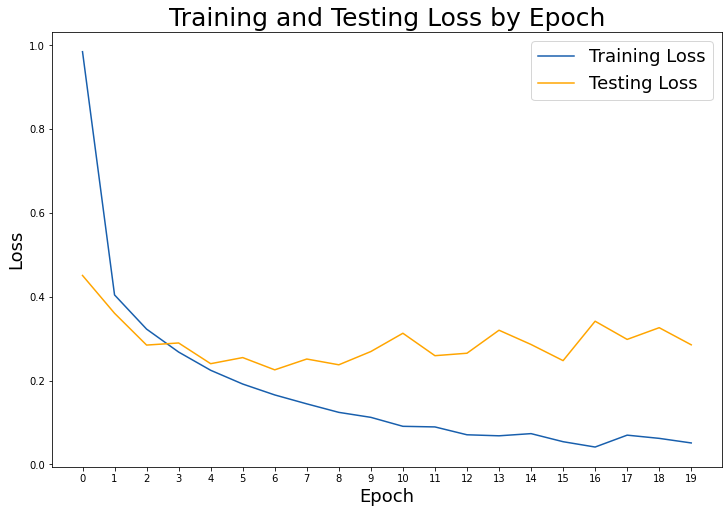

In [121]:
# Check out our train loss and test loss over epochs.
train_loss = hist.history['loss']
test_loss = hist.history['val_loss']
epoch_labels = hist.epoch

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);
plt.savefig('Training_Loss.png')

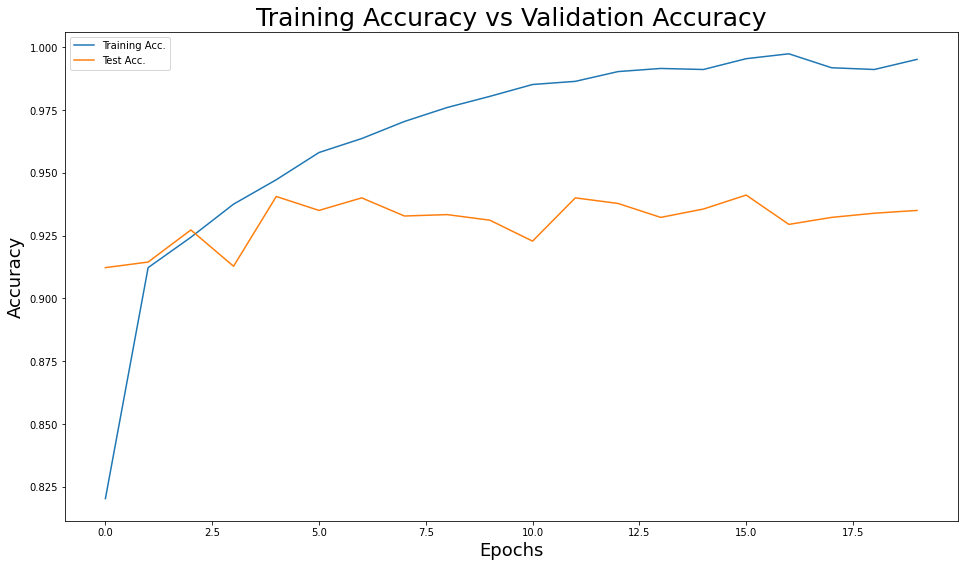

In [122]:
# Visualizing Testing Accuracy vs Validation Accuracy
plt.figure(figsize=(16,9))
plt.plot(hist.history['accuracy'], label = 'Training Acc.')
plt.plot(hist.history['val_accuracy'], label = 'Test Acc.')
plt.title('Training Accuracy vs Validation Accuracy', fontsize = 25)
plt.xlabel('Epochs', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.legend()
plt.savefig('Accuracy.png')
plt.show()